In [55]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

In [56]:
#2021-2022 maçları
years = list(range(2022, 2020, -1))
all_matches = []

In [57]:
# verilerin bulunduğu site
standings_url = "https://fbref.com/en/comps/9/Premier-League-Stats"

In [58]:
import time

# site üzerinden 
for year in years:

    # ana sayfadaki sıralama tablosuna erişim
    data = requests.get(standings_url)
    soup = BeautifulSoup(data.text)
    standings_table = soup.select('table.stats_table')[0]

    # sıralama tablosundan bütün takımların sayfalarına ulaşım
    links = [l.get("href") for l in standings_table.find_all('a')]
    links = [l for l in links if '/squads/' in l]
    team_urls = [f"https://fbref.com{l}" for l in links]
    
    # bir önceki seneye ulaşım
    previous_season = soup.select("a.prev")[0].get("href")
    standings_url = f"https://fbref.com{previous_season}"
    
    # takım maçlarına ve şut istatistiklerine erişim + birleştirme
    for team_url in team_urls:
        team_name = team_url.split("/")[-1].replace("-Stats", "").replace("-", " ")
        data = requests.get(team_url)
        matches = pd.read_html(data.text, match="Scores & Fixtures")[0]
        soup = BeautifulSoup(data.text)
        links = [l.get("href") for l in soup.find_all('a')]
        links = [l for l in links if l and 'all_comps/shooting/' in l]
        data = requests.get(f"https://fbref.com{links[0]}")
        shooting = pd.read_html(data.text, match="Shooting")[0]
        shooting.columns = shooting.columns.droplevel()
        try:
            team_data = matches.merge(shooting[["Date", "Sh", "SoT", "Dist", "FK", "PK", "PKatt"]], on="Date")
            # Sh = Shots total, SoT = Shots on Target, Dis = Average shot distance, FK = Free kick attempt, PK = Penalty kicks made, PKatt = Penalty kick attempt
            # matches tablosu 19 sütun, shooting tablosundan 7 sütun ekleniyor (1'i ortak Date o yüzden 6 sütun)
            # yeni tablo 19 + 6 = 25 sütun olacaktır  
        except ValueError:
            continue

        team_data = team_data[team_data["Comp"] == "Premier League"]
        all_matches.append(team_data)
        time.sleep(1)

ValueError: ignored

In [60]:
# bütün maçlar
match_df = pd.concat(all_matches)
print(len(match_df))

812


In [61]:
# sütunların küçük harfe çevrilmesi
match_df.columns = [c.lower() for c in match_df.columns]

In [62]:
match_df

,date,time,comp,round,day,venue,result,gf,ga,opponent,...,formation,referee,match report,notes,sh,sot,dist,fk,pk,pkatt
1,2022-08-07,16:30,Premier League,Matchweek 1,Sun,Away,W,2.0,0.0,West Ham,...,4-3-3,Michael Oliver,Match Report,NaN,13.0,1.0,18.7,1.0,1,1
2,2022-08-13,15:00,Premier League,Matchweek 2,Sat,Home,W,4.0,0.0,Bournemouth,...,4-2-3-1,David Coote,Match Report,NaN,19.0,7.0,17.5,0.0,0,0
3,2022-08-21,16:30,Premier League,Matchweek 3,Sun,Away,D,3.0,3.0,Newcastle Utd,...,4-3-3,Jarred Gillett,Match Report,NaN,21.0,10.0,16.2,1.0,0,0
4,2022-08-27,15:00,Premier League,Matchweek 4,Sat,Home,W,4.0,2.0,Crystal Palace,...,4-2-3-1,Darren England,Match Report,NaN,18.0,5.0,14.1,0.0,0,0
5,2022-08-31,19:30,Premier League,Matchweek 5,Wed,Home,W,6.0,0.0,Nott'ham Forest,...,4-2-3-1,Paul Tierney,Match Report,NaN,17.0,9.0,14.8,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55,2022-04-30,12:30,Premier League,Matchweek 35,Sat,Away,W,1,0,Newcastle Utd,...,4-3-3,Andre Marriner,Match Report,NaN,24.0,10.0,17.7,2.0,0,0
57,2022-05-07,19:45,Premier League,Matchweek 36,Sat,Home,D,1,1,Tottenham,...,4-3-3,Michael Oliver,Match Report,NaN,22.0,3.0,19.6,1.0,0,0
58,2022-05-10,20:00,Premier League,Matchweek 33,Tue,Away,W,2,1,Aston Villa,...,4-3-3,Jonathan Moss,Match Report,NaN,17.0,5.0,17.0,2.0,0,0
60,2022-05-17,19:45,Premier League,Matchweek 37,Tue,Away,W,2,1,Southampton,...,4-3-3,Martin Atkinson,Match Report,NaN,24.0,5.0,18.6,0.0,0,0


In [63]:
match_df.to_csv("matches.csv")

In [64]:
matches = pd.read_csv("matches.csv", index_col=0)
print(matches.shape)

(812, 25)


In [65]:
# attribute tipleri
matches.dtypes

date             object
time             object
comp             object
round            object
day              object
venue            object
result           object
gf              float64
ga              float64
opponent         object
xg              float64
xga             float64
poss            float64
attendance      float64
captain          object
formation        object
referee          object
match report     object
notes           float64
sh              float64
sot             float64
dist            float64
fk              float64
pk                int64
pkatt             int64
dtype: object

In [66]:
# kullanılmayacak özelliklerin silinmesi
del matches["date"]
del matches["time"]
del matches["comp"]
del matches["round"]
del matches["day"]
#del matches["result"]
#del matches["gf"] # atılan gol
#del matches["ga"] # yenilen gol
del matches["attendance"]
del matches["captain"]
del matches["formation"]
del matches["referee"]
del matches["match report"]
del matches["notes"]
del matches["venue"]
del matches["opponent"]

In [67]:
print(matches.shape)
matches

(812, 12)


,result,gf,ga,xg,xga,poss,sh,sot,dist,fk,pk,pkatt
1,W,2.0,0.0,2.2,0.5,75.0,13.0,1.0,18.7,1.0,1,1
2,W,4.0,0.0,1.7,0.1,67.0,19.0,7.0,17.5,0.0,0,0
3,D,3.0,3.0,2.1,1.8,69.0,21.0,10.0,16.2,1.0,0,0
4,W,4.0,2.0,2.2,0.1,74.0,18.0,5.0,14.1,0.0,0,0
5,W,6.0,0.0,3.3,0.7,74.0,17.0,9.0,14.8,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
55,W,1.0,0.0,2.3,0.2,64.0,24.0,10.0,17.7,2.0,0,0
57,D,1.0,1.0,1.3,0.9,64.0,22.0,3.0,19.6,1.0,0,0
58,W,2.0,1.0,1.8,1.4,60.0,17.0,5.0,17.0,2.0,0,0
60,W,2.0,1.0,1.3,0.1,70.0,24.0,5.0,18.6,0.0,0,0


In [68]:
!pip install scikit-learn
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from scipy.stats import ttest_rel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [69]:
# sınıflandırma modellerinin listeye aktarımı

models = []
models.append(('LO', make_pipeline(StandardScaler(), LogisticRegression())))
models.append(('DE', make_pipeline(StandardScaler(), DecisionTreeClassifier())))
models.append(('RA', make_pipeline(StandardScaler(), RandomForestClassifier())))
models.append(('SV', make_pipeline(StandardScaler(), SVC())))
models.append(('GA', make_pipeline(StandardScaler(), GaussianNB())))

In [70]:
print(matches.shape)
matches.dtypes

(812, 12)


result     object
gf        float64
ga        float64
xg        float64
xga       float64
poss      float64
sh        float64
sot       float64
dist      float64
fk        float64
pk          int64
pkatt       int64
dtype: object

LO: Mean Accuracy: 1.0, Standard Deviation: 0.0
DE: Mean Accuracy: 1.0, Standard Deviation: 0.0
RA: Mean Accuracy: 0.975444143330322, Standard Deviation: 0.025732351213316455
SV: Mean Accuracy: 0.9655525444143329, Standard Deviation: 0.015305485992946549
GA: Mean Accuracy: 0.6773411623005119, Standard Deviation: 0.031564204381764355


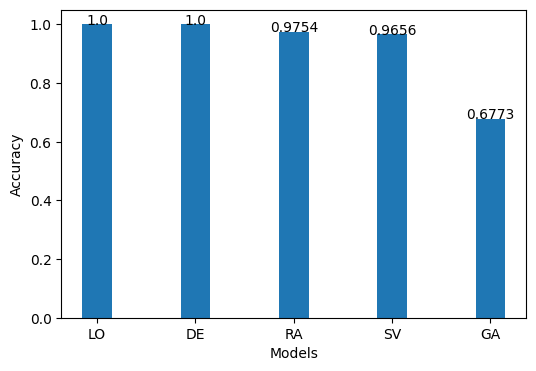

In [71]:
from matplotlib import pyplot as plt

# gf, ga içerdiğinden accuracy yüksek

X = matches.drop(columns=['result'], axis=1)
Y = matches['result']

results = []
names = []

for name, model in models:
    # cv = 10
    kfold = KFold(n_splits=10, random_state=42, shuffle=True)
    cv_results = cross_val_score(model, X, Y, cv=kfold, scoring='accuracy')
    results.append(round(cv_results.mean(), 4))
    names.append(name)
    print(f'{name}: Mean Accuracy: {cv_results.mean()}, Standard Deviation: {cv_results.std()}')

fig = plt.figure(figsize = (6, 4))
plt.bar(names, results, width = 0.3)
plt.xlabel("Models")
plt.ylabel("Accuracy")

for i in range(len(names)):
    plt.text(i , results[i], results[i], ha = 'center')

plt.show()

LO: Mean Accuracy: 0.6146492020475761, Standard Deviation: 0.05245574164265853
DE: Mean Accuracy: 0.5124811803673592, Standard Deviation: 0.04994867273058227
RA: Mean Accuracy: 0.5715146040349293, Standard Deviation: 0.03904278732606016
SV: Mean Accuracy: 0.5937067148449263, Standard Deviation: 0.05046744553383083
GA: Mean Accuracy: 0.5604336043360434, Standard Deviation: 0.061255457239868534


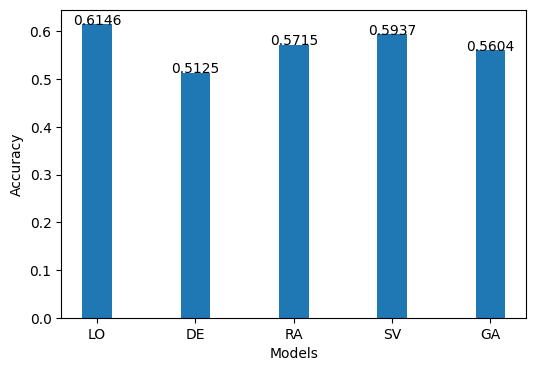

LO vs DE: t-statistic = 6.091992851312702, p-value = 0.00018099521437470815
LO vs RA: t-statistic = 3.455162261619535, p-value = 0.007215677616334405
LO vs SV: t-statistic = 2.4394046141133776, p-value = 0.03740114484648506
LO vs GA: t-statistic = 4.125816928641489, p-value = 0.0025754995562662945
DE vs RA: t-statistic = -4.065283190155422, p-value = 0.0028195145271658743
DE vs SV: t-statistic = -5.070647728476006, p-value = 0.0006712816107777747
DE vs GA: t-statistic = -2.8601804767420287, p-value = 0.01877486693574382
RA vs SV: t-statistic = -2.6427335138825803, p-value = 0.026793446006614978
RA vs GA: t-statistic = 0.7123216648568377, p-value = 0.49431657838737375
SV vs GA: t-statistic = 2.7229590887249606, p-value = 0.02349373691807308


In [72]:
X = matches.drop(columns=['result', 'ga', 'gf'], axis=1)
Y = matches['result']

results = []
names = []
results_ttest = []

for name, model in models:
    # cv = 10
    kfold = KFold(n_splits=10, random_state=42, shuffle=True)
    cv_results = cross_val_score(model, X, Y, cv=kfold, scoring='accuracy')
    results.append(round(cv_results.mean(), 4))
    results_ttest.append(cv_results)
    names.append(name)
    print(f'{name}: Mean Accuracy: {cv_results.mean()}, Standard Deviation: {cv_results.std()}')


# grafik
fig = plt.figure(figsize = (6, 4))
plt.bar(names, results, width = 0.3)
plt.xlabel("Models")
plt.ylabel("Accuracy")

for i in range(len(names)):
    plt.text(i , results[i], results[i], ha = 'center')

plt.show()

for i in range(len(results_ttest)):
    for j in range(i+1, len(results_ttest)):
        t_statistic, p_value = ttest_rel(results_ttest[i], results_ttest[j])
        print(f'{names[i]} vs {names[j]}: t-statistic = {t_statistic}, p-value = {p_value}')

In [73]:
import numpy as np
from sklearn.linear_model import BayesianRidge, Lasso, ElasticNet, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# regresyon modellerinin listeye aktarımı
regression_models = []

regression_models.append(('BAY', make_pipeline(StandardScaler(), BayesianRidge())))
regression_models.append(('LAS', make_pipeline(StandardScaler(), Lasso())))
regression_models.append(('ELA', make_pipeline(StandardScaler(), ElasticNet())))
regression_models.append(('DEC', make_pipeline(StandardScaler(), DecisionTreeRegressor())))
regression_models.append(('LIN', make_pipeline(StandardScaler(), LinearRegression())))

In [74]:
# regression için
matches = matches.drop(columns=['result'])

In [75]:
matches

,gf,ga,xg,xga,poss,sh,sot,dist,fk,pk,pkatt
1,2.0,0.0,2.2,0.5,75.0,13.0,1.0,18.7,1.0,1,1
2,4.0,0.0,1.7,0.1,67.0,19.0,7.0,17.5,0.0,0,0
3,3.0,3.0,2.1,1.8,69.0,21.0,10.0,16.2,1.0,0,0
4,4.0,2.0,2.2,0.1,74.0,18.0,5.0,14.1,0.0,0,0
5,6.0,0.0,3.3,0.7,74.0,17.0,9.0,14.8,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
55,1.0,0.0,2.3,0.2,64.0,24.0,10.0,17.7,2.0,0,0
57,1.0,1.0,1.3,0.9,64.0,22.0,3.0,19.6,1.0,0,0
58,2.0,1.0,1.8,1.4,60.0,17.0,5.0,17.0,2.0,0,0
60,2.0,1.0,1.3,0.1,70.0,24.0,5.0,18.6,0.0,0,0


BAY: Mean Squared Error: 0.3475975641079928,  Standard Deviation: 0.04337638983147828
LAS: Mean Squared Error: 0.6276988473699205,  Standard Deviation: 0.12972953412437033
ELA: Mean Squared Error: 0.6276988473699205,  Standard Deviation: 0.12972953412437033
DEC: Mean Squared Error: 0.75425669978922,  Standard Deviation: 0.11675083101494939
LIN: Mean Squared Error: 0.3482188709483648,  Standard Deviation: 0.04275881237917693


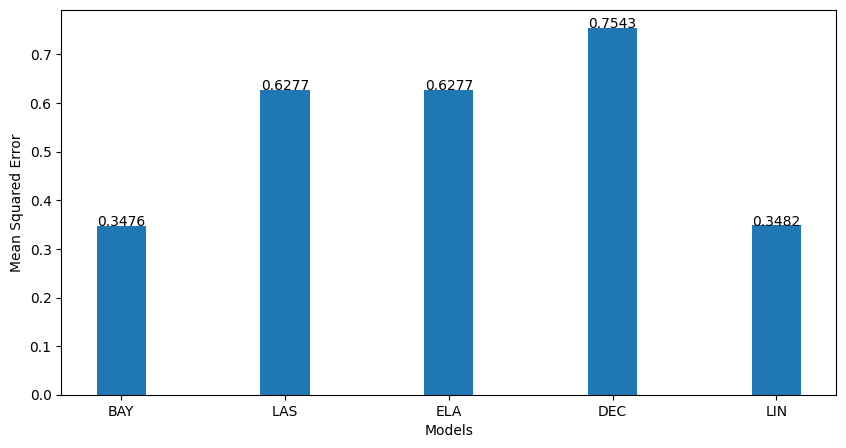

In [76]:
X = matches.drop(columns=['xga'], axis=1)
Y = matches['xga']

results = []
names = []

for name, model in regression_models:
    kfold = KFold(n_splits=10, random_state=42, shuffle=True)
    cv_results = cross_val_score(model, X, Y, cv=kfold, scoring='neg_mean_squared_error')
    results.append(round(cv_results.mean() * -1, 4))
    names.append(name)
    print(f'{name}: Mean Squared Error: {cv_results.mean() * -1},  Standard Deviation: {cv_results.std()}')

fig = plt.figure(figsize = (10, 5))
plt.bar(names, results, width = 0.3)
plt.xlabel("Models")
plt.ylabel("Mean Squared Error")

for i in range(len(names)):
    plt.text(i , results[i], results[i], ha = 'center')

plt.show()

In [ ]:
X = matches.drop(columns=['xg'], axis=1)
y = matches['xg']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

results = []
names = []

for name, model in regression_models:
    kfold = KFold(n_splits=10, random_state=42, shuffle=True)
    cv_results = cross_val_score(model, X, Y, cv=kfold, scoring='neg_mean_squared_error')
    nmse = round(cv_results.mean() * -1, 4)
    results.append(nmse)
    names.append(name)
    std = round(cv_results.std(), 4)
    print(f'{name}: Mean Squared Error: {nmse},  Standard Deviation: {std}')

fig = plt.figure(figsize = (5, 3))
plt.bar(names, results, width = 0.3)
plt.xlabel("Models")
plt.ylabel("Mean Squared Error")

for i in range(len(names)):
    plt.text(i , results[i], results[i], ha = 'center')

plt.show()

print("-----------------------------------------------------------------------------------------")

X = matches.drop(columns=['xg','sh'], axis=1)
Y = matches['xg']

results = []
names = []

for name, model in regression_models:
    kfold = KFold(n_splits=10, random_state=42, shuffle=True)
    cv_results = cross_val_score(model, X, Y, cv=kfold, scoring='neg_mean_squared_error')
    nmse = round(cv_results.mean() * -1, 4)
    results.append(nmse)
    names.append(name)
    std = round(cv_results.std(), 4)
    print(f'{name}: Mean Squared Error: {nmse},  Standard Deviation: {std}')

fig = plt.figure(figsize = (5, 3))
plt.bar(names, results, width = 0.3)
plt.xlabel("Models")
plt.ylabel("Mean Squared Error")

for i in range(len(names)):
    plt.text(i , results[i], results[i], ha = 'center')

plt.show()

print("-----------------------------------------------------------------------------------------")

X = matches.drop(columns=['xg','sh','sot'], axis=1)
Y = matches['xg']

results = []
names = []

for name, model in regression_models:
    kfold = KFold(n_splits=10, random_state=42, shuffle=True)
    cv_results = cross_val_score(model, X, Y, cv=kfold, scoring='neg_mean_squared_error')
    nmse = round(cv_results.mean() * -1, 4)
    results.append(nmse)
    names.append(name)
    std = round(cv_results.std(), 4)
    print(f'{name}: Mean Squared Error: {nmse},  Standard Deviation: {std}')

fig = plt.figure(figsize = (5, 3))
plt.bar(names, results, width = 0.3)
plt.xlabel("Models")
plt.ylabel("Mean Squared Error")

for i in range(len(names)):
    plt.text(i , results[i], results[i], ha = 'center')

plt.show()

In [ ]:
# root mean square error örnekleri
X = matches.drop(columns=['poss'], axis=1)
Y = matches['poss']

results = []
names = []

for name, model in regression_models:
    kfold = KFold(n_splits=10, random_state=42, shuffle=True)
    cv_results = cross_val_score(model, X, Y, cv=kfold, scoring='neg_mean_squared_error')
    names.append(name)
    rmse = round(np.sqrt(cv_results.mean() * -1), 4)
    results.append(rmse)
    std = round(cv_results.std(), 4)
    print(f'{name}: Mean Squared Error: {rmse},  Standard Deviation: {std}')

fig = plt.figure(figsize = (5, 3))
plt.bar(names, results, width = 0.3)
plt.xlabel("Models")
plt.ylabel("Root Mean Squared Error")

for i in range(len(names)):
    plt.text(i , results[i], results[i], ha = 'center')

plt.show()

print("-----------------------------------------------------------------------------------------")

X = matches.drop(columns=['poss','xg'], axis=1)
Y = matches['poss']

results = []
names = []

for name, model in regression_models:
    kfold = KFold(n_splits=10, random_state=42, shuffle=True)
    cv_results = cross_val_score(model, X, Y, cv=kfold, scoring='neg_mean_squared_error')
    names.append(name)
    rmse = round(np.sqrt(cv_results.mean() * -1), 4)
    results.append(rmse)
    std = round(cv_results.std(), 4)
    print(f'{name}: Root Mean Squared Error: {rmse},  Standard Deviation: {std}')

fig = plt.figure(figsize = (5, 3))
plt.bar(names, results, width = 0.3)
plt.xlabel("Models")
plt.ylabel("Root Mean Squared Error")

for i in range(len(names)):
    plt.text(i , results[i], results[i], ha = 'center')

plt.show()